In [1]:
# This script has been adapted from Luke Chang's naturalistic-data.org tutorial. 

# Dependent Packages
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from nltools.mask import create_sphere, expand_mask
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
import warnings

/home/local/TU/tui81100/.local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Defining our directories
data_dir = '/data/Uncertainty/data/deriv/pipeline_1/fmriprep'

# Quick-customize Variables
roi = 221               # Identifying which ROI we want to focus on; see "ROIs_Schaefer.txt" for a full list. 
task = "uncertainty"    # Identifying the name of the task at hand
voxel_index = 15        # arbitrary voxel which we can use to examine pairwise correlations between subjects across a timecourse 
tr_index = 100          # arbitrary TR which we can use to examine spatial topography

In [3]:
# ----- ALIGNMENT BEGINS -----
print("Alignment has begun! | " + str(datetime.datetime.now()))

# Reading in cortical parcellations
# mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')                            # Chang parcellation
# mask = Brain_Data('https://www.nitrc.org/frs/download.php/7976/shen_1mm_268_parcellation.nii.gz')       # Finn et al., 2015 Parcellation (https://www.nature.com/articles/nn.4135!#Sec18)
mask = Brain_Data('/data/tools/schaefer_parcellations/MNI/Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_1mm.nii.gz')   # Schaefer / Kong 2022 17Network 400 Parcellations

# Splitting the one collection of parcellations into separate binary masks for each region
mask_x = expand_mask(mask)

# Creating a solitary mask for our ROI of interest
roi_mask = mask_x[roi]
print("Parcellations have downloaded! | " + str(datetime.datetime.now()))

# Identifying all of the files that meet our naming criteria
file_list = glob.glob(os.path.join(data_dir, '*', 'func', f'*run-2*preproc_bold*hdf5'))
print("Relevant files have been identified! | " + str(datetime.datetime.now()))

Alignment has begun! | 2023-10-20 00:10:06.911003
Parcellations have downloaded! | 2023-10-20 00:10:08.796093
Relevant files have been identified! | 2023-10-20 00:10:08.801895


sub-6021's run-2 data has loaded | 2023-10-20 00:10:13.565961
sub-6971's run-2 data has loaded | 2023-10-20 00:10:14.671075
sub-7492's run-2 data has loaded | 2023-10-20 00:10:15.519329
sub-3952's run-2 data has loaded | 2023-10-20 00:10:16.611365
sub-8621's run-2 data has loaded | 2023-10-20 00:10:17.465424
sub-3274's run-2 data has loaded | 2023-10-20 00:10:18.557690
sub-2758's run-2 data has loaded | 2023-10-20 00:10:19.375623
sub-2610's run-2 data has loaded | 2023-10-20 00:10:20.460346
sub-2579's run-2 data has loaded | 2023-10-20 00:10:21.264660
sub-3046's run-2 data has loaded | 2023-10-20 00:10:22.358642
sub-8607's run-2 data has loaded | 2023-10-20 00:10:23.165630
sub-6799's run-2 data has loaded | 2023-10-20 00:10:24.297642
sub-8929's run-2 data has loaded | 2023-10-20 00:10:25.395413
sub-4781's run-2 data has loaded | 2023-10-20 00:10:26.483617
sub-6269's run-2 data has loaded | 2023-10-20 00:10:27.572694
sub-0208's run-2 data has loaded | 2023-10-20 00:10:28.653889
sub-4407

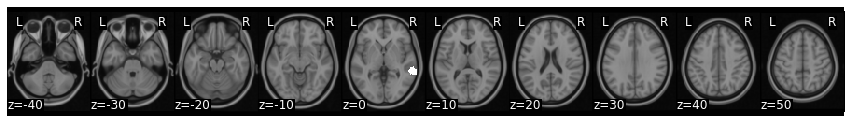

In [4]:
# Creating an empty array to hold all of our data
all_data = []

# Iterating through each of our previously identified files
for f in file_list:

    # Identifying this participant's ID (which will be the first element in this array)
    sub = os.path.basename(f).split('_')[0]

    # Identifying this file's run number (which will be the third element in this array)
    run = os.path.basename(f).split('_')[2]

    # Reading in the data for this file
    data = Brain_Data(f)
    print(str(sub) + "'s " + str(run) + " data has loaded | " + str(datetime.datetime.now()))

    # Appending the data within the confines of our mask to the end of our empty data array
    all_data.append(data.apply_mask(roi_mask))

# Visualizing our ROI
roi_mask.plot()
print("Mask" + str(roi)+ "is being plotted! | " + str(datetime.datetime.now()))

# Conducting hyper alignment
hyperalign = align(all_data[:], method='procrustes')
print("Hyperalignment has completed! | " + str(datetime.datetime.now()))

In [5]:
# ----- PLOTTING ALIGNED VOXEL TIMECOURSE -----

# Creating dataframes that contain information for voxel plots
voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in all_data]).T
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

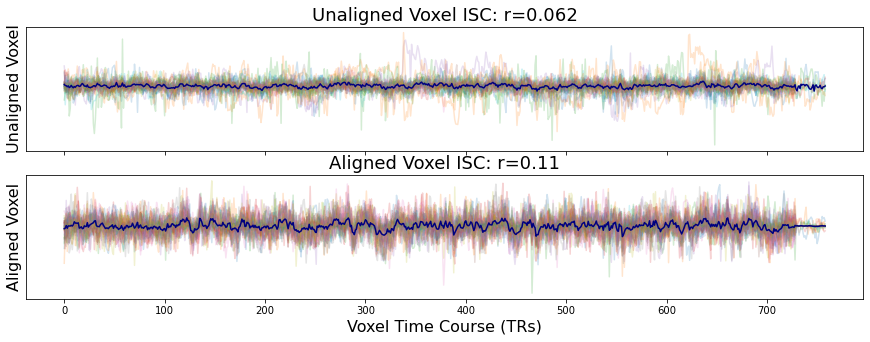

In [6]:
# Generating the master plot on which both ISC figures will be housed
f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)

# Generating plots to view how similar activity is across participants using ISC and unaligned voxels
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

# Generating plots to view how similar activity is across participants using ISC and unaligned voxels
a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

# Adding labels and titles to the master plot
plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)

# Saving the master plot
plt.savefig('/data/Uncertainty/data/deriv/pipeline_1/plots/voxel_time_course.png')

In [ ]:
# ----- PLOTTING HISTOGRAM of ISC VALUES ACROSS ALL VOXELS -----

# Resetting the plot function
plt.figure()

# Generating the image, and labeling said image
plt.hist(hyperalign['isc'].values())
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Hyperalignment ISC', fontsize=18)

# Printing the mean ISC value
print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

# Saving the figure
plt.savefig('/data/Uncertainty/data/deriv/pipeline_1/plots/hyperalignment_isc.png')

In [ ]:
# ----- EXAMINING HOW HYPERALIGNMENT IMPACTED SPATIAL TOPOGRAPHY -----

# Resetting the plot function
plt.figure()

# Generating the image and labeling said image
f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(2):
    sns.heatmap(np.rot90(all_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])
a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

# Saving the figure
plt.tight_layout()
plt.savefig('/data/Uncertainty/data/deriv/pipeline_1/plots/transformed_data.png')